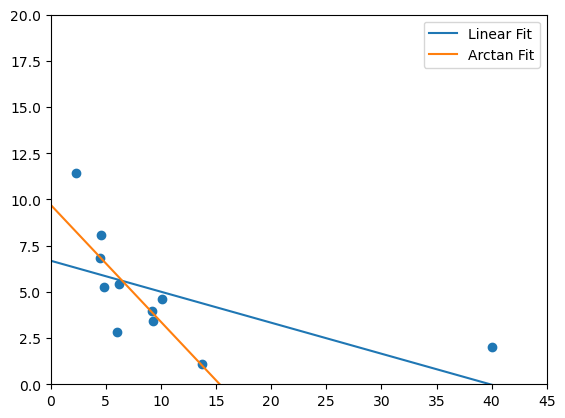

In [3]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import least_squares
# from sklearn.metrics import r2_score, mean_squared_error

#This is a fairly standard linear model
def model(params, x):
    return params[0]*x + params[1]

# This defines the residuals orthogonal to the regression line
def residuals(params, x, y):
    return (y - model(params, x))/np.sqrt(1 + params[0]**2)

# This performs ODR regression for Y against X with initial guess init using least_squares()
def odr(X,Y, init, res = residuals, loss='linear', bounds=([-100, 0], [-1/100, 16]), f_scale=.1):
    result = least_squares(res, init, loss = loss, f_scale=f_scale, args=(X,Y), bounds = bounds)
    
    # a is the slope of the line, b is the intercept
    a, b = result.x
    return a, b

#Generate date points normally with a slope of -1
X = []
Y = []
for i in range(10):
    X.append(np.abs(np.random.normal(2+i,2)))
    Y.append(np.abs(np.random.normal(10-i,1)))

#Append an outlier for a demonstration
X.append(40)
Y.append(2)

#Change to np.array to allow for multiplication by scalar
X=np.array(X)
Y=np.array(Y)

#Define the two x-values to plot the line of best fit between
plot_line = np.array([0,45])

#plot with linear loss
coefs = odr(X,Y,[-1,np.max(Y)])
plt.plot(plot_line,model(coefs, plot_line), label=f"Linear Fit")

#plot with arctan loss
coefs = odr(X,Y,[-1,np.max(Y)],loss='arctan',f_scale=1)
plt.plot(plot_line,model(coefs, plot_line), label=f"Arctan Fit")

#legend
plt.legend()

#data points
plt.scatter(X,Y)
#plot limits
plt.xlim(0,45)
plt.ylim(0,20)

plt.show()

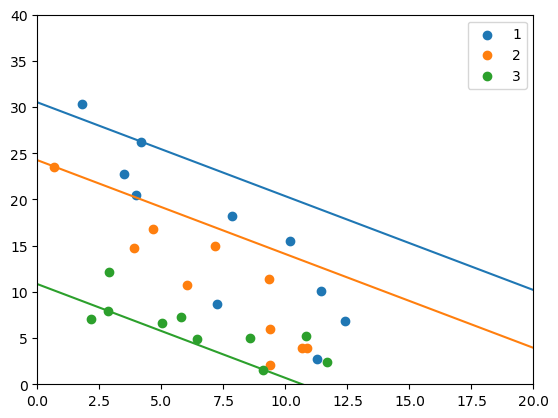

[-1.0154451  30.50916107 24.24927655 10.83839532]


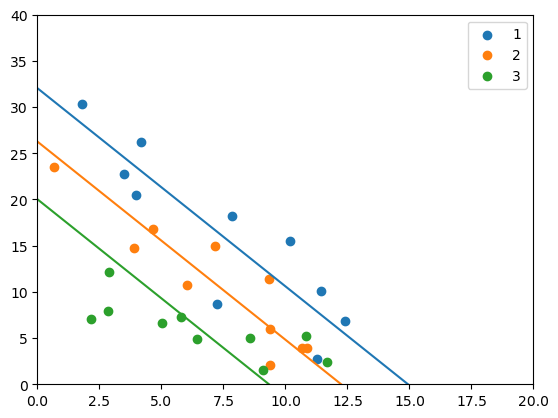

[-2.14432385 32.0393978  26.2604675  20.01720955]


In [7]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import least_squares
import pandas as pd

#This is a fairly standard linear model
def model(params, x):
    return params[0]*x + params[1]

def parallel_model(params, x):
    # print(x)
    common_slope, *parallel = params

    # Get all columns starting with 'Beam'
    beam_columns = [col for col in x.columns if col.startswith('Beam')]
    return common_slope*x['X'] + np.dot(x[beam_columns], parallel)

def parallel_residuals(params, x, y, model = parallel_model):
    model_output = model(params, x)
    # print(y.T.values[0])
    return (y.T.values[0] - model_output)/np.sqrt(1 + params[0]**2)

def parallel_odr(dataframe, maxes, init = -1, lb = -100, ub = -1/100, model = parallel_model, res = parallel_residuals, loss='arctan', f_scale=.1):
    """
    Performs the parallel orthogonal distance regression on the given dataset.
    
    dataset - Pandas Dataframe with columns Eg, Ev, and Beam _ for each beam with data.
    maxes - Array that holds the initial y_intercept guess for each beam. If only Beams 5 and 6 made it, then there are only two values in this array.
    init - Initial slope guess
    lb - Lower bound constraint for slope
    ub - Upper bound constraint for slope
    model - Model to estimate Ev and Eg.
    res - Residuals to put into least_squares function
    loss - Loss function in regression
    f_scale - f_scale parameter for least_squares, affects how much it cares about outliers.
    """
   
    # cats is the number of groundtracks that have data that we could read
    cats = dataframe.shape[1]-2
    
    # a is the lower bound of the parameters, [slope, intercept_for_first_dataset, etc.]
    # b is the upper bound, same setup.
    # We then put it together into a bounds variable that we can use in least_squares()
    a = [lb] + [0]*cats
    b = [ub] + [50]*cats
    bounds = (a,b)
    
    # Initial guess [slope, y_intercept_first_dataset, y_intercept_second_dataset, etc.]
    initial_params = [init] + maxes
    
    # Just like in machine learning, we drop Y from the data to be our dependent variable
    # and we keep everything else, our features, in X.
    X = dataframe.drop(columns=['Y'])
    Y = dataframe[['Y']]
    
    # We call least_squares to do the heavy lifting for us.
    params = least_squares(res, x0=initial_params, args=(X, Y, model), loss = loss, f_scale=f_scale, bounds = bounds,\
        ftol = 1e-15, xtol=1e-15, gtol=1e-15).x
    
    # Return the resulting coefficients
    return params

#Generate date points
X1 = []
Y1 = []
for i in range(10):
    X1.append(np.abs(np.random.normal(2+i,2)))
    Y1.append(np.abs(np.random.normal(30-3*i,1)))

X2 = []
Y2 = []
for i in range(10):
    X2.append(np.abs(np.random.normal(2+i,1)))
    Y2.append(np.abs(np.random.normal(20-2*i,2)))

X3 = []
Y3 = []
for i in range(10):
    X3.append(np.abs(np.random.normal(2+i,1)))
    Y3.append(np.abs(np.random.normal(10-.9*i,1.5)))

Xs = [X1,X2,X3]
Ys = [Y1,Y2,Y3]

dataset = []
maxes = []
for i in range(len(Xs)):
    for x,y in zip(Xs[i],Ys[i]):
        dataset.append([x, y, i])
    maxes.append(np.max(Ys[i]))

# Make a dataframe from the data
dataframe = pd.DataFrame(dataset, columns=['X', 'Y', 'Beam'])

# Dummy encode the categorical variable
dataframe_encoded = pd.get_dummies(dataframe, columns=['Beam'], prefix='Beam', prefix_sep='')







#retrieve the coefficients from the parallel ODR
coefs = parallel_odr(dataframe_encoded, maxes=maxes, loss='arctan', f_scale=.1)

plot_line = np.array([0,20])
for i in range(len(Xs)):
    plt.scatter(Xs[i],Ys[i],label=f"{i+1}")
    plt.plot(plot_line, model([coefs[0],coefs[i+1]],plot_line))

#plot limits
plt.xlim(0,20)
plt.ylim(0,40)
plt.legend()
plt.show()
print(coefs)



#retrieve the coefficients from the parallel ODR
coefs = parallel_odr(dataframe_encoded, maxes=maxes, loss='linear')

plot_line = np.array([0,20])
for i in range(len(Xs)):
    plt.scatter(Xs[i],Ys[i],label=f"{i+1}")
    plt.plot(plot_line, model([coefs[0],coefs[i+1]],plot_line))

#plot limits
plt.xlim(0,20)
plt.ylim(0,40)
plt.legend()
plt.show()
print(coefs)

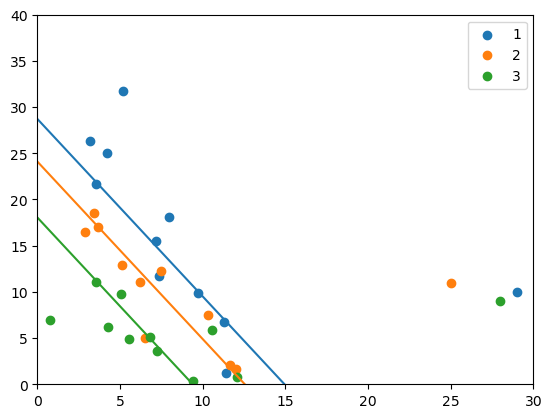

[-1.92092615 28.70358044 24.09039276 18.03765244]


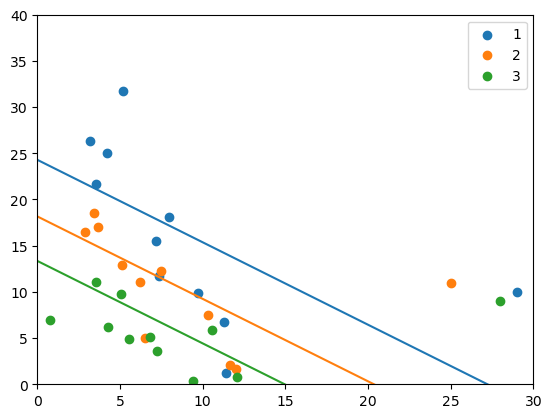

[-0.89226348 24.28354351 18.15877643 13.34207274]


In [19]:
from matplotlib import pyplot as plt
import numpy as np
from scipy.optimize import least_squares
import pandas as pd

#This is a fairly standard linear model
def model(params, x):
    return params[0]*x + params[1]

def parallel_model(params, x):
    # print(x)
    common_slope, *parallel = params

    # Get all columns starting with 'Beam'
    beam_columns = [col for col in x.columns if col.startswith('Beam')]
    return common_slope*x['X'] + np.dot(x[beam_columns], parallel)

def parallel_residuals(params, x, y, model = parallel_model):
    model_output = model(params, x)
    # print(y.T.values[0])
    return (y.T.values[0] - model_output)/np.sqrt(1 + params[0]**2)

def parallel_odr(dataframe, maxes, init = -1, lb = -100, ub = -1/100, model = parallel_model, res = parallel_residuals, loss='arctan', f_scale=.1):
    """
    Performs the parallel orthogonal distance regression on the given dataset.
    
    dataset - Pandas Dataframe with columns Eg, Ev, and Beam _ for each beam with data.
    maxes - Array that holds the initial y_intercept guess for each beam. If only Beams 5 and 6 made it, then there are only two values in this array.
    init - Initial slope guess
    lb - Lower bound constraint for slope
    ub - Upper bound constraint for slope
    model - Model to estimate Ev and Eg.
    res - Residuals to put into least_squares function
    loss - Loss function in regression
    f_scale - f_scale parameter for least_squares, affects how much it cares about outliers.
    """
   
    # cats is the number of groundtracks that have data that we could read
    cats = dataframe.shape[1]-2
    
    # a is the lower bound of the parameters, [slope, intercept_for_first_dataset, etc.]
    # b is the upper bound, same setup.
    # We then put it together into a bounds variable that we can use in least_squares()
    a = [lb] + [0]*cats
    b = [ub] + [50]*cats
    bounds = (a,b)
    
    # Initial guess [slope, y_intercept_first_dataset, y_intercept_second_dataset, etc.]
    initial_params = [init] + maxes
    
    # Just like in machine learning, we drop Y from the data to be our dependent variable
    # and we keep everything else, our features, in X.
    X = dataframe.drop(columns=['Y'])
    Y = dataframe[['Y']]
    
    # We call least_squares to do the heavy lifting for us.
    params = least_squares(res, x0=initial_params, args=(X, Y, model), loss = loss, f_scale=f_scale, bounds = bounds,\
        ftol = 1e-15, xtol=1e-15, gtol=1e-15).x
    
    # Return the resulting coefficients
    return params

#Generate date points
X1 = []
Y1 = []
for i in range(10):
    X1.append(np.abs(np.random.normal(2+i,2)))
    Y1.append(np.abs(np.random.normal(30-3*i,1)))
X1.append(29)
Y1.append(10)

X2 = []
Y2 = []
for i in range(10):
    X2.append(np.abs(np.random.normal(2+i,1)))
    Y2.append(np.abs(np.random.normal(20-2*i,2)))
X2.append(25)
Y2.append(11)

X3 = []
Y3 = []
for i in range(10):
    X3.append(np.abs(np.random.normal(2+i,1)))
    Y3.append(np.abs(np.random.normal(10-.9*i,1.5)))
X3.append(28)
Y3.append(9)

Xs = [X1,X2,X3]
Ys = [Y1,Y2,Y3]

dataset = []
maxes = []
for i in range(len(Xs)):
    for x,y in zip(Xs[i],Ys[i]):
        dataset.append([x, y, i])
    maxes.append(np.max(Ys[i]))

# Make a dataframe from the data
dataframe = pd.DataFrame(dataset, columns=['X', 'Y', 'Beam'])

# Dummy encode the categorical variable
dataframe_encoded = pd.get_dummies(dataframe, columns=['Beam'], prefix='Beam', prefix_sep='')






M = 30

#retrieve the coefficients from the parallel ODR
coefs = parallel_odr(dataframe_encoded, maxes=maxes, loss='arctan', f_scale=1)

plot_line = np.array([0,M])
for i in range(len(Xs)):
    plt.scatter(Xs[i],Ys[i],label=f"{i+1}")
    plt.plot(plot_line, model([coefs[0],coefs[i+1]],plot_line))

#plot limits
plt.xlim(0,M)
plt.ylim(0,40)
plt.legend()
plt.show()
print(coefs)



#retrieve the coefficients from the parallel ODR
coefs = parallel_odr(dataframe_encoded, maxes=maxes, loss='linear')

plot_line = np.array([0,M])
for i in range(len(Xs)):
    plt.scatter(Xs[i],Ys[i],label=f"{i+1}")
    plt.plot(plot_line, model([coefs[0],coefs[i+1]],plot_line))

#plot limits
plt.xlim(0,M)
plt.ylim(0,40)
plt.legend()
plt.show()
print(coefs)